In [1]:
# Dataset
import kagglehub
from kagglehub import KaggleDatasetAdapter

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import f_oneway, kruskal, chi2_contingency
import matplotlib.pyplot as plt



/Users/sakshamb/Desktop/Projects/spotify-artist-prediction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downloading the latest version of the dataset
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")

print("Path to dataset files:", path)


Path to dataset files: /Users/sakshamb/.cache/kagglehub/datasets/maharshipandya/-spotify-tracks-dataset/versions/1


In [3]:
df = pd.read_csv(path + '/dataset.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [4]:
features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
target = 'popularity'
popular_threshold = 60 

In [5]:
# === prepare X, y ===
X = df[features].copy()
y = df[target].copy()

In [6]:
# === preprocessing (median impute + scaling) ===
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [7]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, features),
    # If you want to include genre:
    # ('genre', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')), 
    #                     ('ohe', OneHotEncoder(handle_unknown='ignore'))]), ['track_genre'])
])

X_proc = preprocessor.fit_transform(X) 

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_proc)
print("Explained variance by two PCA components:", pca.explained_variance_ratio_.sum())


Explained variance by two PCA components: 0.3243967857460849


**Note:**
The below takes like 15 minutes to run

In [10]:
# === find good K for KMeans by silhouette score ===
sil_scores = {}
db_scores = {}
K_range = range(2, 11)   # try 2..10 clusters
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_proc)
    sil = silhouette_score(X_proc, labels)
    db = davies_bouldin_score(X_proc, labels)
    sil_scores[k] = sil
    db_scores[k] = db
    print(f"k={k}: silhouette={sil:.4f}, davies_bouldin={db:.4f}")

k=2: silhouette=0.1966, davies_bouldin=2.0128
k=3: silhouette=0.2124, davies_bouldin=1.8454
k=4: silhouette=0.1178, davies_bouldin=2.1820
k=5: silhouette=0.1180, davies_bouldin=2.1158
k=6: silhouette=0.1262, davies_bouldin=1.9900
k=7: silhouette=0.1296, davies_bouldin=1.8715
k=8: silhouette=0.1237, davies_bouldin=1.7877
k=9: silhouette=0.1306, davies_bouldin=1.6832
k=10: silhouette=0.1356, davies_bouldin=1.6243


In [11]:
best_k = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", best_k)

Best k by silhouette: 3


In [12]:
kfinal = best_k
kmeans = KMeans(n_clusters=kfinal, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_proc)
df['cluster_kmeans'] = clusters

In [19]:
cluster_summary = df.groupby('cluster_kmeans')[target].agg(
    count='count',
    mean_popularity='mean',
    median_popularity='median',
    std_popularity='std'
).reset_index().sort_values('mean_popularity', ascending=False)

In [20]:
df['popular_binary'] = (df[target] >= popular_threshold).astype(int)
popular_by_cluster = df.groupby('cluster_kmeans')['popular_binary'].agg(
    n_popular='sum',
    cluster_size='count'
).reset_index()
popular_by_cluster['popular_rate'] = popular_by_cluster['n_popular'] / popular_by_cluster['cluster_size']

In [21]:
cluster_summary = cluster_summary.merge(popular_by_cluster, on='cluster_kmeans')
print(cluster_summary)

   cluster_kmeans  count  mean_popularity  median_popularity  std_popularity  \
0               2  10049        36.028062               36.0       24.051829   
1               0  77578        33.545283               35.0       22.292440   
2               1  26373        31.273310               31.0       21.476877   

   n_popular  cluster_size  popular_rate  
0       1905         10049      0.189571  
1      10324         77578      0.133079  
2       2593         26373      0.098320  


In [22]:
groups = [group[target].values for _, group in df.groupby('cluster_kmeans')]
f_stat, pval = f_oneway(*groups)
print(f"ANOVA F={f_stat:.3f}, p={pval:.3e}")

ANOVA F=188.907, p=1.243e-82


In [23]:
h_stat, h_pval = kruskal(*groups)
print(f"Kruskal-Wallis H={h_stat:.3f}, p={h_pval:.3e}")

Kruskal-Wallis H=327.292, p=8.500e-72


In [24]:
contingency = pd.crosstab(df['cluster_kmeans'], df['popular_binary'])
chi2, chi_p, dof, ex = chi2_contingency(contingency)
print("Chi-square:", chi2, "p-value:", chi_p)

Chi-square: 555.7679309718005 p-value: 2.072655771538088e-121


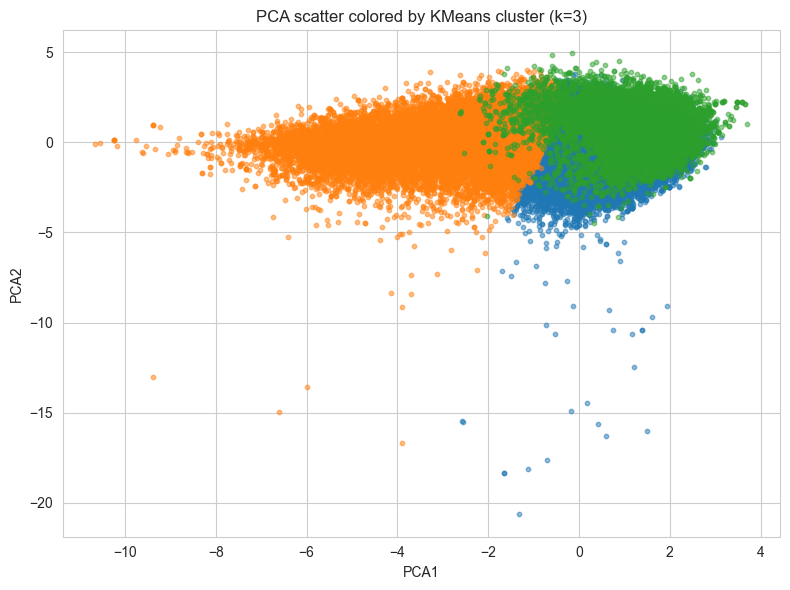

In [25]:
# === Visualize PCA colored by cluster (one plot) ===

plt.figure(figsize=(8,6))
for c in sorted(df['cluster_kmeans'].unique()):
    mask = df['cluster_kmeans'] == c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=10, alpha=0.5)
plt.title(f'PCA scatter colored by KMeans cluster (k={kfinal})')
plt.xlabel('PCA1'); plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

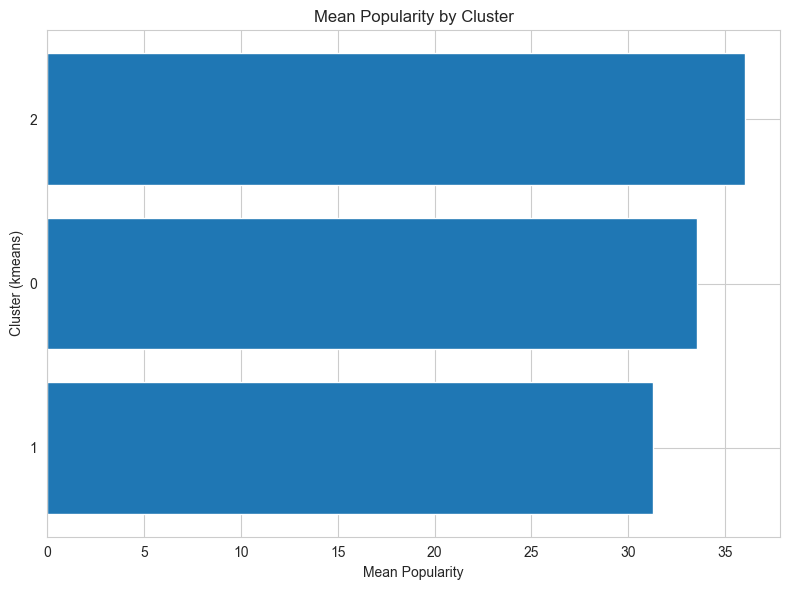

In [26]:
# === bar chart: mean popularity per cluster ===
cluster_summary_sorted = cluster_summary.sort_values('mean_popularity', ascending=True)
plt.figure(figsize=(8,6))
plt.barh(cluster_summary_sorted['cluster_kmeans'].astype(str), cluster_summary_sorted['mean_popularity'])
plt.xlabel('Mean Popularity')
plt.ylabel('Cluster (kmeans)')
plt.title('Mean Popularity by Cluster')
plt.tight_layout()
plt.show()

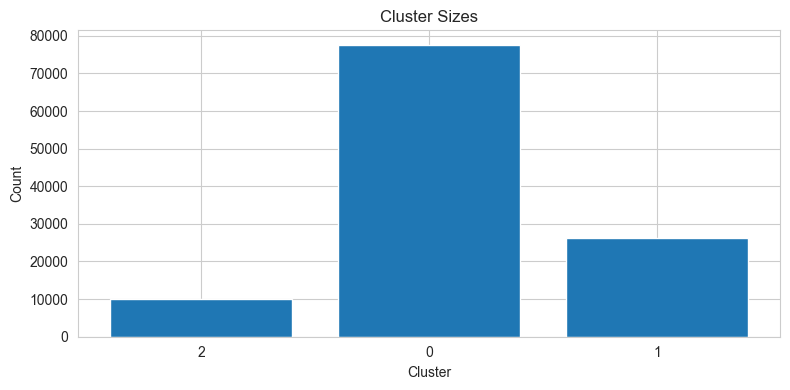

In [27]:

# === Cluster sizes ===
plt.figure(figsize=(8,4))
plt.bar(cluster_summary['cluster_kmeans'].astype(str), cluster_summary['count'])
plt.xlabel('Cluster'); plt.ylabel('Count'); plt.title('Cluster Sizes')
plt.tight_layout()
plt.show()

In [28]:
# === Optionally: compute silhouette per-sample and inspect low-score points ===
from sklearn.metrics import silhouette_samples
samp_sil = silhouette_samples(X_proc, clusters)
df['silhouette'] = samp_sil
# show worst silhouette samples
print(df.sort_values('silhouette').head()[['track_name', 'artists', 'cluster_kmeans', 'silhouette']])

                                 track_name         artists  cluster_kmeans  \
54023                             On My Way           Serph               1   
63979   古いラヴ・レター (セルフカバー) - Remastered 2022  Eikichi Yazawa               1   
92313   古いラヴ・レター (セルフカバー) - Remastered 2022  Eikichi Yazawa               1   
55958                              Rahguzar      Adarsh Rao               1   
106815           Hundratusen (feat. GAMMAL)   Petter;GAMMAL               1   

        silhouette  
54023    -0.086587  
63979    -0.084377  
92313    -0.084377  
55958    -0.083624  
106815   -0.082270  


In [29]:
import pandas as pd
import numpy as np

# Your numeric features used in KMeans
cluster_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Group by cluster and compute descriptive stats
cluster_summary = df.groupby("cluster_kmeans")[cluster_features].agg(['mean', 'median', 'std'])

cluster_summary


duration_ms                           explicit         \
                         mean    median            std      mean median   
cluster_kmeans                                                            
0               234641.842275  218666.0  106521.336853  0.000013    0.0   
1               217611.018276  199772.0  117286.722927  0.001668    0.0   
2               204321.149368  193400.0   75658.205189  0.965469    1.0   

                         danceability                     energy  ...  \
                     std         mean median       std      mean  ...   
cluster_kmeans                                                    ...   
0               0.003590     0.593167  0.604  0.157064  0.747928  ...   
1               0.040812     0.463386  0.474  0.178777  0.297328  ...   
2               0.182597     0.634652  0.652  0.171176  0.721807  ...   

                liveness   valence                        tempo           \
                     std      mean median       std        mean   median   
cluster_kmeans                                                             
0               0.194341  0.529121  0.536  0.253321  126.273508  124.989   
1               0.158553  0.313241  0.272  0.217143  110.295550  108.746   
2               0.219810  0.471146  0.472  0.228263  121.403397  119.925   

                          time_signature                   
                      std           mean median       std  
cluster_kmeans                                             
0               28.289613       3.965132    4.0  0.251801  
1               31.259882       3.707163    4.0  0.708538  
2               30.851686       3.949050    4.0  0.428614  

[3 rows x 42 columns]

In [30]:
# Compute overall means/stds
overall_mean = df[cluster_features].mean()
overall_std = df[cluster_features].std()

# Compute cluster means
cluster_means = df.groupby("cluster_kmeans")[cluster_features].mean()

# Compute z-scores
cluster_zscores = (cluster_means - overall_mean) / overall_std

cluster_zscores


,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster_kmeans,,,,,,,,,,,,,,
0,0.061629,-0.305720,0.151934,0.423590,0.032282,0.366571,-0.038696,-0.060162,-0.412284,-0.121922,0.041691,0.212343,0.137622,0.141225
1,-0.097096,-0.299800,-0.595902,-1.367852,-0.099640,-1.203483,0.158137,-0.294015,1.313332,0.490474,-0.193585,-0.620328,-0.395364,-0.455069
2,-0.220955,3.146956,0.390982,0.319741,0.012284,0.328553,-0.116292,1.236075,-0.263943,-0.345981,0.186201,-0.011272,-0.024833,0.104051


### Cluster Profiles (K-Means)

#### Cluster 0 - "Mainstream Energetic Pop"
- Energy & loudness: above average (high-energy, louder tracks)
- Danceability: slightly above average
- Valence: positive / upbeat
- Acousticness: low (more electronic/produced)
- Instrumentalness: low (mostly vocal tracks)
- Tempo: slightly faster than average
- Explicit: mostly non-explicit
- Interpretation: Catchy, radio-friendly songs typical of mainstream pop and dance-pop.

#### Cluster 1 - "Low-Energy Acoustic / Indie"
- Energy & loudness: very low (soft, quiet tracks)
- Danceability: low
- Acousticness: very high
- Instrumentalness: fairly high
- Valence: lower (more somber or introspective)
- Tempo: lower than average
- Explicit: mostly non-explicit
- Interpretation: Acoustic, indie, ambient, or instrumental tracks; mellow and niche.

#### Cluster 2 - "Speech-Heavy / Explicit (Hip-Hop / Rap)"
- Speechiness: very high
- Explicit: very high
- Danceability: high
- Energy: moderately high
- Acousticness: low
- Instrumentalness: low (vocally focused)
- Liveness: slightly above average
- Interpretation: Rap, hip-hop, and vocal-heavy tracks with strong lyrical presence; often explicit.



#### GMM

In [13]:
gmm = GaussianMixture(n_components=kfinal, random_state=42)
gmm_labels = gmm.fit_predict(X_proc)
df['cluster_gmm'] = gmm_labels

In [14]:
sil = silhouette_score(X_proc, gmm_labels)
db = davies_bouldin_score(X_proc, gmm_labels)

print(f"Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")

Silhouette Score: 0.1543
Davies-Bouldin Score: 3.3009


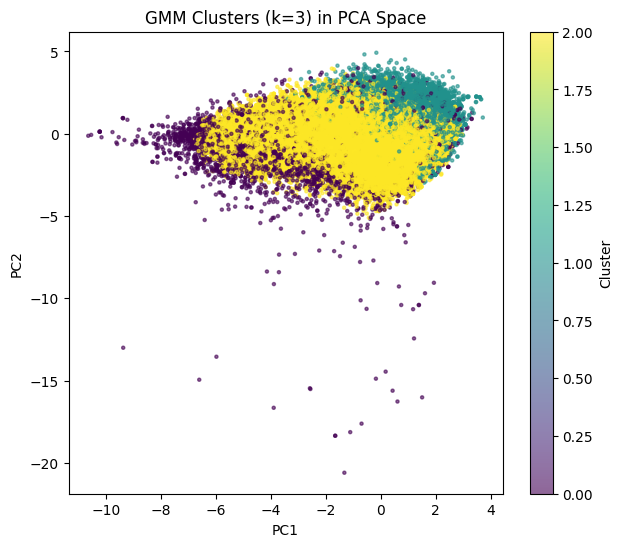

In [15]:
plt.figure(figsize=(7,6))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=gmm_labels,
    cmap="viridis",
    s=5,
    alpha=0.6
)
plt.title(f"GMM Clusters (k={kfinal}) in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [16]:
popular_threshold = 60
df["is_popular"] = (df["popularity"] >= popular_threshold).astype(int)

cluster_stats_gmm = df.groupby("cluster_gmm").agg(
    count=("popularity", "count"),
    mean_popularity=("popularity", "mean"),
    median_popularity=("popularity", "median"),
    std_popularity=("popularity", "std"),
    n_popular=("is_popular", "sum"),
).reset_index()

cluster_stats_gmm["popular_rate"] = cluster_stats_gmm["n_popular"] / cluster_stats_gmm["count"]

print(cluster_stats_gmm)

   cluster_gmm  count  mean_popularity  median_popularity  std_popularity  \
0            0   5683        31.331867               29.0       21.073605   
1            1  15308        34.283969               34.0       23.590993   
2            2  93009        33.182972               35.0       22.151129   

   n_popular  popular_rate  
0        633      0.111385  
1       2541      0.165992  
2      11648      0.125235  


In [17]:
# Popularity numeric comparisons
groups = [
    df[df["cluster_gmm"] == k]["popularity"]
    for k in sorted(df["cluster_gmm"].unique())
]

anova_stat, anova_p = f_oneway(*groups)
kw_stat, kw_p = kruskal(*groups)

print(f"\nANOVA: F={anova_stat:.3f}, p={anova_p:.3e}")
print(f"Kruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.3e}")

# Chi-square for binary popular vs cluster
contingency = pd.crosstab(df["cluster_gmm"], df["is_popular"])
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency)

print(f"\nChi-square: {chi2_stat} p={chi2_p}")


ANOVA: F=37.890, p=3.548e-17
Kruskal-Wallis: H=73.247, p=1.243e-16

Chi-square: 211.3889669190239 p=1.2516101197295183e-46


## Clustering Analysis: GMM vs. K-Means

### Gaussian Mixture Model (GMM)
GMM was used to cluster songs into 3 probabilistic groups based on audio features.  
Cluster characteristics:

| Cluster | Count | Mean Popularity | Median | Std | Popular Songs | Popular Rate |
|--------|-------|------------------|--------|-----|----------------|--------------|
| 0 | 5,683 | 31.33 | 29 | 21.07 | 633 | 11.1% |
| 1 | 15,308 | 34.28 | 34 | 23.59 | 2,541 | 16.6% |
| 2 | 93,009 | 33.18 | 35 | 22.15 | 11,648 | 12.5% |

**Statistical tests**  
- ANOVA: F = 37.890, p = 3.548e-17  
- Kruskal–Wallis: H = 73.247, p = 1.243e-16  
- Chi-square: 211.389, p = 1.25e-46  

These results indicate **significant differences between GMM clusters**, but with modest separation.

---

### K-Means Clustering
K-Means was also run with 3 clusters using the same features.  
Cluster characteristics:

| Cluster | Count | Mean Popularity | Median | Std | Popular Songs | Popular Rate |
|--------|-------|------------------|--------|-----|----------------|--------------|
| 2 | 10,049 | 36.03 | 36 | 24.05 | 1,905 | 18.96% |
| 0 | 77,578 | 33.55 | 35 | 22.29 | 10,324 | 13.31% |
| 1 | 26,373 | 31.27 | 31 | 21.47 | 2,593 | 9.83% |

**Statistical tests**  
- ANOVA: F = 188.907, p = 1.243e-82  
- Kruskal–Wallis: H = 327.292, p = 8.50e-72  
- Chi-square: 555.768, p = 2.07e-121  

These values are dramatically higher than those for GMM, indicating **much stronger separation** between K-Means clusters.

---

### **Which Clustering Algorithm Performed Better?**

**K-Means clearly produced more distinct and better-separated clusters.**

Evidence:
- All statistical tests (ANOVA, Kruskal–Wallis, Chi-square) have **much larger test statistics** and **much smaller p-values** than GMM.
- K-Means produced the **highest-popularity cluster**:  
  - **Cluster 2 popular rate = 18.96%**, better than GMM’s best cluster (16.6%).
- Cluster differences under K-Means are more pronounced and better aligned with popularity.

**Conclusion:**  
**K-Means was the superior clustering method in this dataset**, showing stronger cluster separation and clearer popularity patterns compared to GMM.
